### Basic Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('/Users/eduardo/Desktop/AssetPricing/data.csv')
#print(df.head())
#print(df.describe())
print(df.columns)

Index(['KEY', 'FREQ', 'REF_AREA', 'CURRENCY', 'PROVIDER_FM', 'INSTRUMENT_FM',
       'PROVIDER_FM_ID', 'DATA_TYPE_FM', 'TIME_PERIOD', 'OBS_VALUE',
       'OBS_STATUS', 'OBS_CONF', 'OBS_PRE_BREAK', 'OBS_COM', 'TIME_FORMAT',
       'BREAKS', 'COLLECTION', 'COMPILING_ORG', 'DISS_ORG', 'DOM_SER_IDS',
       'FM_CONTRACT_TIME', 'FM_COUPON_RATE', 'FM_IDENTIFIER', 'FM_LOT_SIZE',
       'FM_MATURITY', 'FM_OUTS_AMOUNT', 'FM_PUT_CALL', 'FM_STRIKE_PRICE',
       'PUBL_MU', 'PUBL_PUBLIC', 'UNIT_INDEX_BASE', 'COMPILATION', 'COVERAGE',
       'DECIMALS', 'SOURCE_AGENCY', 'SOURCE_PUB', 'TITLE', 'TITLE_COMPL',
       'UNIT', 'UNIT_MULT'],
      dtype='object')


### Convert `df` from long to wide and keep useful columns

In [3]:
# Parse dates
df["TIME_PERIOD"] = pd.to_datetime(df["TIME_PERIOD"])

# Keep only government bond Svensson params
mask = (
    (df["REF_AREA"] == "U2") &
    (df["CURRENCY"] == "EUR") &
    (df["PROVIDER_FM"] == "4F") &
    (df["INSTRUMENT_FM"] == "G_N_A") &
    (df["PROVIDER_FM_ID"] == "SV_C_YM")
)

df_yc = df.loc[mask, ["TIME_PERIOD", "DATA_TYPE_FM", "OBS_VALUE"]].copy()

# Pivot: rows = date, columns = parameter
yc_params = df_yc.pivot_table(
    index="TIME_PERIOD",
    columns="DATA_TYPE_FM",
    values="OBS_VALUE"
).sort_index()

needed_cols = ["BETA0", "BETA1", "BETA2", "BETA3", "TAU1", "TAU2"]
yc_params = yc_params[needed_cols]

yc_params.head()

DATA_TYPE_FM,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2
TIME_PERIOD,,,,,,
2004-09-06,5.410510,-3.462358,-0.361335,-0.466368,3.128331,1.489535
2004-09-07,5.391886,-3.450353,-0.372908,-0.271295,3.157868,1.548566
2004-09-08,5.385978,-3.447950,-0.346505,-0.198077,3.137857,1.553148
2004-09-09,5.377333,-3.432592,-0.382208,-0.293482,3.271392,1.521143
2004-09-10,5.355732,-3.395283,-0.375382,-0.507894,3.279876,1.479197


### Implement Svensson formula & compute yields

In [5]:
# maturities in yrs
maturities = np.array([0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 30.0])

# make sure params are floats
params = yc_params[["BETA0", "BETA1", "BETA2", "BETA3", "TAU1", "TAU2"]].astype(float)
b0 = params["BETA0"].values
b1 = params["BETA1"].values
b2 = params["BETA2"].values
b3 = params["BETA3"].values
t1 = params["TAU1"].values
t2 = params["TAU2"].values

def svensson_spot_rate(T, beta0, beta1, beta2, beta3, tau1, tau2):

    x1 = T / tau1
    x2 = T / tau2

    # avoid division by zero
    x1 = np.where(x1 == 0, 1e-6, x1)
    x2 = np.where(x2 == 0, 1e-6, x2)

    term1 = (1.0 - np.exp(-x1)) / x1
    term2 = term1 - np.exp(-x1)
    term3 = (1.0 - np.exp(-x2)) / x2 - np.exp(-x2)

    return beta0 + beta1 * term1 + beta2 * term2 + beta3 * term3

# build yc df: rows = dates, columns = maturities
yc_yields = pd.DataFrame(index=yc_params.index)

for T in maturities:
    yc_yields[f"y_{T}y"] = svensson_spot_rate(T, b0, b1, b2, b3, t1, t2)

### Plot each maturity evelution

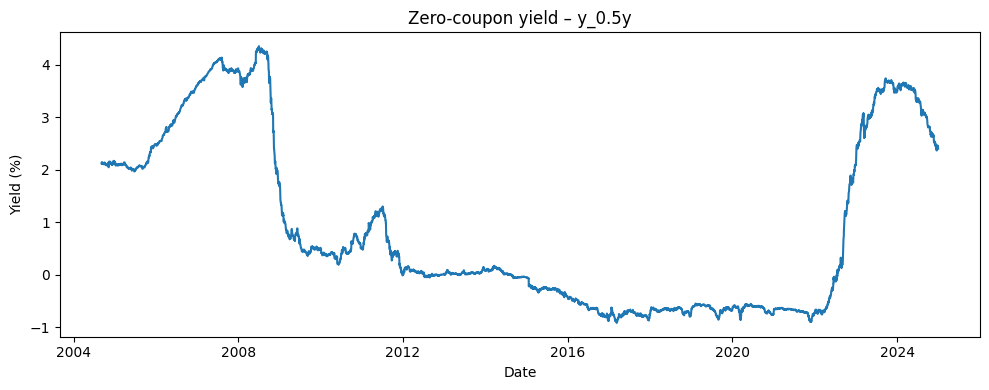

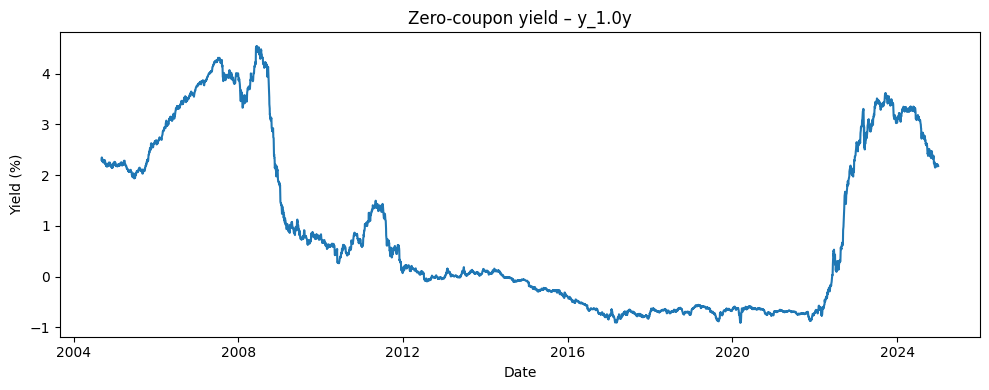

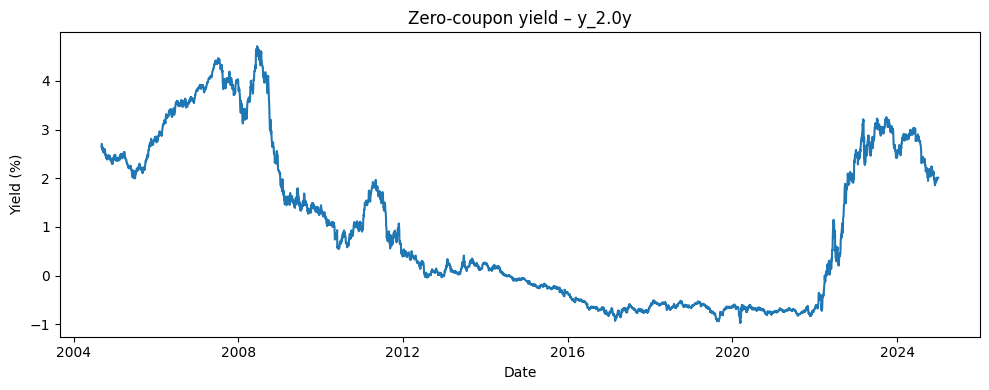

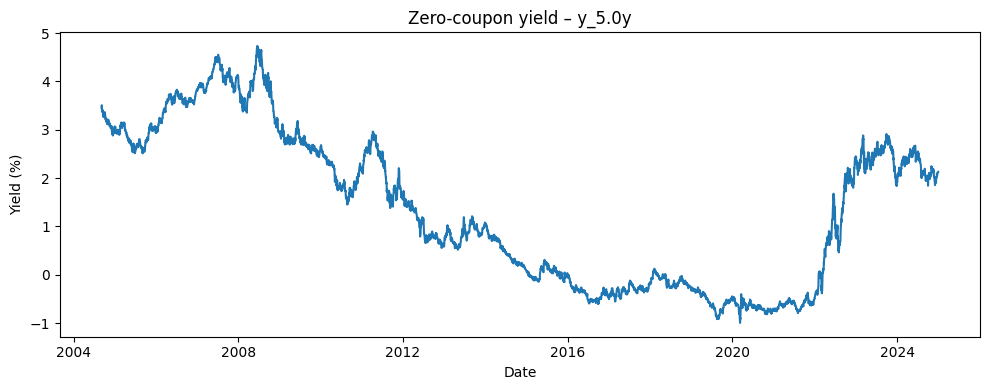

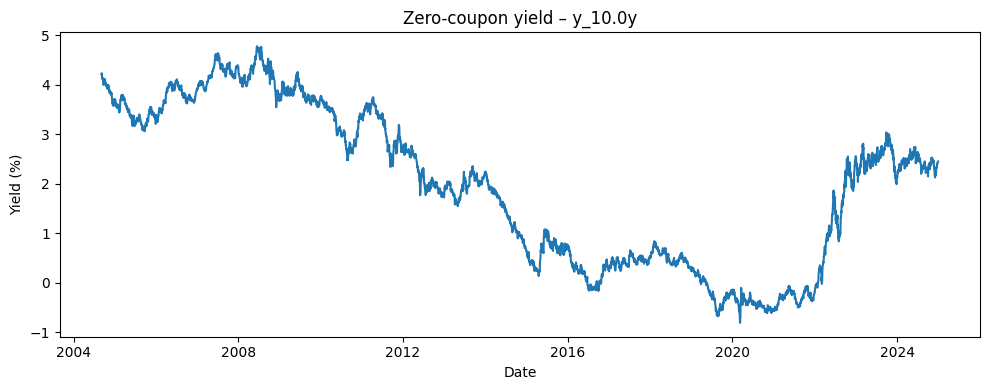

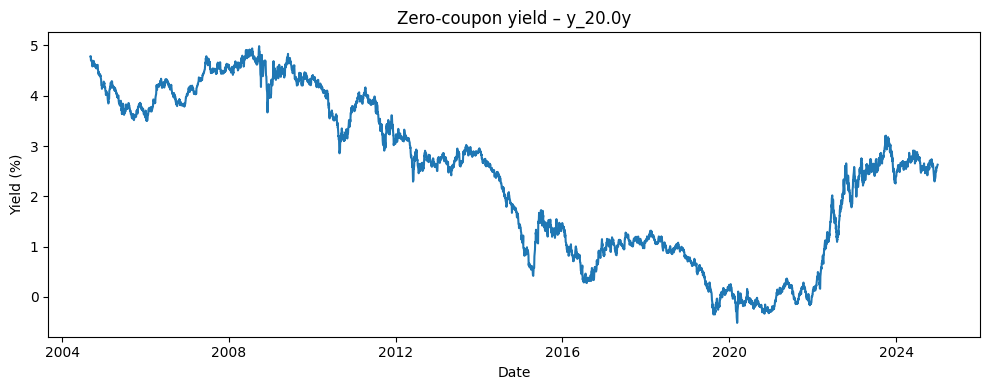

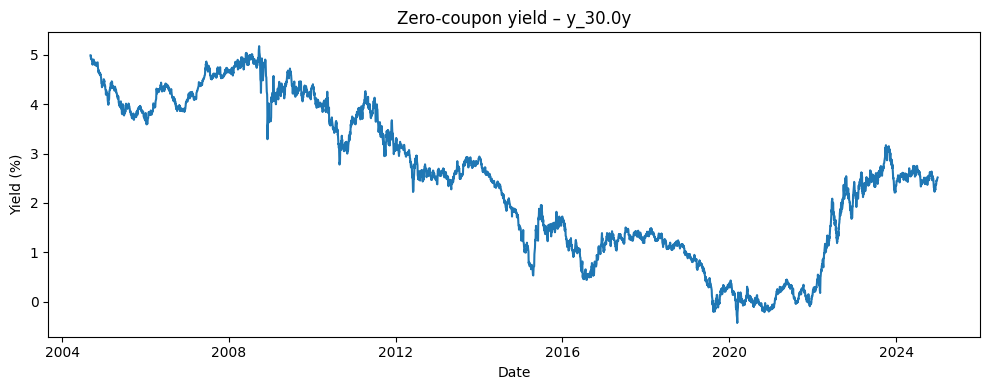

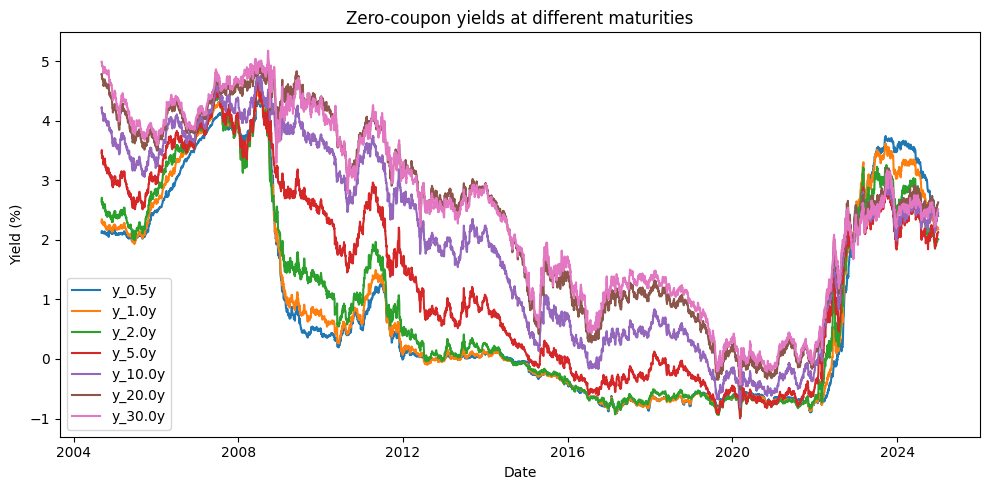

In [6]:
# A 2D plot for each maturity
for col in yc_yields.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(yc_yields.index, yc_yields[col])
    plt.title(f"Zero-coupon yield – {col}")
    plt.xlabel("Date")
    plt.ylabel("Yield (%)")
    plt.tight_layout()
    plt.show()

# One 2D plot with ALL maturities together
plt.figure(figsize=(10, 5))
for col in yc_yields.columns:
    plt.plot(yc_yields.index, yc_yields[col], label=col)

plt.title("Zero-coupon yields at different maturities")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.legend()
plt.tight_layout()
plt.show()

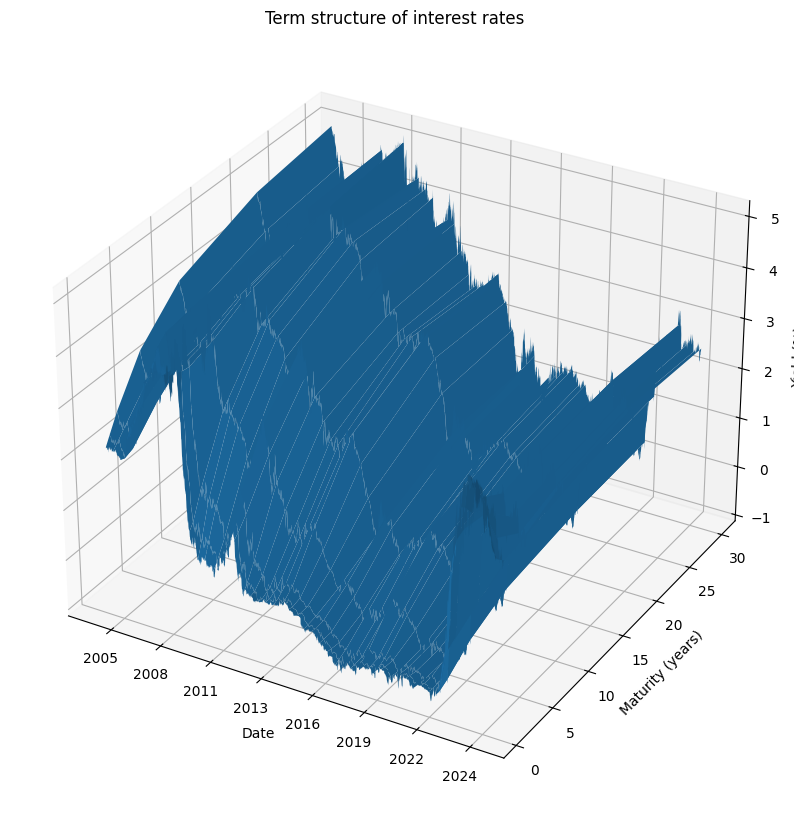

In [7]:
import matplotlib.dates as mdates

# Convert dates to numbers
dates_num = mdates.date2num(yc_yields.index.to_pydatetime())

# Extract maturities from column names
maturities = np.array([float(c.split("_")[1].replace("y", "")) for c in yc_yields.columns])

# Create grid: X = time, Y = maturity
X, Y = np.meshgrid(dates_num, maturities)

# Z = yields (transpose to match shapes)
Z = yc_yields.values.T

fig = plt.figure(figsize=(10, 14))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True)

ax.set_xlabel("Date")
ax.set_ylabel("Maturity (years)")
ax.set_zlabel("Yield (%)")
ax.set_title("Term structure of interest rates ")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

### Plot bond price over time

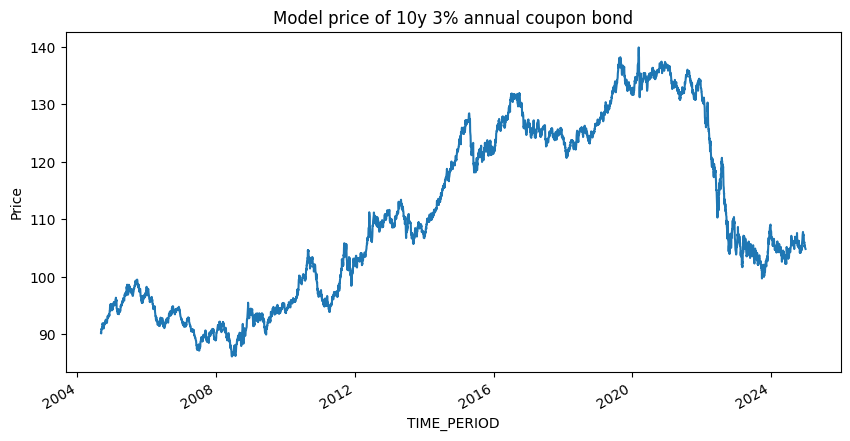

In [9]:
bond_price_series.plot(figsize=(10,5))
plt.title("Model price of 10y 3% annual coupon bond")
plt.ylabel("Price")
plt.show()

### Utility functions: discount factors & PV bond pricing

In [28]:
# Returns yield
def get_short_rate(yc_params, date):
    """Get true instantaneous short rate from Svensson beta0"""
    return yc_params.loc[date, "BETA0"] / 100.0

# Build discount factors using the term structure
def discount_factors_from_curve(yc_yields, date, payment_times):
    """Proper interpolation of zero rates for exact payment times"""
    available_maturities = np.array([0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 30.0])
    yields_on_date = yc_yields.loc[date].values / 100.0

    # Interpolate to get exact yields for payment times
    from scipy.interpolate import CubicSpline
    cs = CubicSpline(available_maturities, yields_on_date)
    exact_yields = cs(payment_times)

    dfs = 1.0 / (1.0 + exact_yields) ** payment_times
    return dfs

# Obtain Present Value
def price_coupon_bond_pv(yc_yields, date, maturity, coupon_rate,
                         face=100.0, freq=1):
    n_periods = int(maturity * freq)
    dt = 1.0 / freq

    payment_times = np.arange(1, n_periods + 1) * dt
    coupon_cf = face * coupon_rate / freq
    cash_flows = np.full(n_periods, coupon_cf, dtype=float)
    cash_flows[-1] += face

    dfs = discount_factors_from_curve(yc_yields, date, payment_times)

    price_pv = np.sum(cash_flows * dfs)
    return price_pv

In [29]:
# Quick check
val_date = yc_yields.index[0]
pv_price = price_coupon_bond_pv(yc_yields, val_date, maturity=10, coupon_rate=0.03)
print("PV price from ECB curve:", pv_price)

PV price from ECB curve: 90.94139157095282


### Martingale-style binomial short-rate tree pricing

Simple CRR-style binomial tree for the short rate
- r0: initial short rate (decimal)
- sigma: volatility of short rate per sqrt(year)
- dt: time step in years
- N: number of time steps

Price a fixed-coupon bond on a short-rate tree under Q.
- r_tree: (N+1, N+1) array of short rates (decimal)
- q: risk-neutral up probability
- dt: length of one time step (years)
- maturity: bond maturity in YEARS
- coupon_rate: annual coupon rate (e.g. 0.03 for 3%)
- freq: coupons per year (assume dt = 1/freq)

In [31]:
# short rate tree
def build_short_rate_tree(r0, sigma, dt, N):

    u = np.exp(sigma * np.sqrt(dt))
    d = 1.0 / u

    # risk-neutral probability so that expected growth factor matches 1 + r0*dt
    R = 1.0 + r0 * dt
    q = (R - d) / (u - d)

    # clip q into [0,1] just in case
    q = min(max(q, 0.0), 1.0)

    r_tree = np.zeros((N + 1, N + 1))
    r_tree[0, 0] = r0

    for n in range(1, N + 1):
        for j in range(n + 1):
            r_tree[n, j] = r0 * (u ** j) * (d ** (n - j))

    return r_tree, q

# using the tree to price the bond
def price_coupon_bond_binomial(r_tree, q, dt, maturity, coupon_rate,
                               face=100.0, freq=1):

    N = int(maturity * freq)
    assert np.isclose(dt, 1.0 / freq), "dt must be 1/freq for this simple implementation"

    coupon_cf = face * coupon_rate / freq

    B = np.zeros((N + 1, N + 1))
    for j in range(N + 1):
        B[N, j] = face

    # Backward induction
    for n in range(N - 1, -1, -1):
        for j in range(n + 1):
            r = r_tree[n, j]
            expected_next = q * B[n + 1, j + 1] + (1 - q) * B[n + 1, j]
            B[n, j] = (expected_next + coupon_cf) / (1.0 + r * dt)

    return B[0, 0]

### Compare PV vs tree prices for the whole sample


Best sigma: 0.5 with RMSE: 10.590999376444522


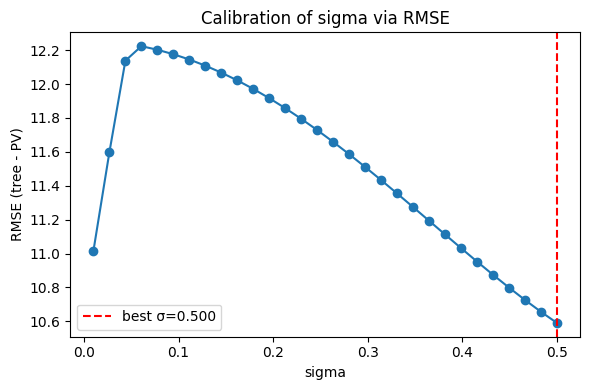

          price_pv   price_tree  diff_tree_minus_pv
count  5195.000000  5195.000000         5195.000000
mean    111.178367   109.630748           -1.547619
std      15.248342    13.859418           10.478324
min      86.172871    81.387383          -15.880635
25%      96.737038    96.893748           -8.960083
50%     108.609581   112.772284           -3.686148
75%     125.810530   120.660274            2.952508
max     140.072632   134.065789           37.217976


In [38]:
# Bond & model specs
maturity = 10
coupon_rate = 0.03
face = 100.0
freq = 1
dt = 1.0 / freq


def compute_rmse_for_sigma(sigma, yc_yields, maturity, coupon_rate,
                           face=100.0, freq=1, max_dates=None):
    """
    For a given sigma, compute RMSE between tree price and PV price over the sample
    """
    dt = 1.0 / freq
    dates = yc_yields.index
    if max_dates is not None:
        dates = dates[:max_dates]

    diffs = []

    for d in dates:
        pv_price = price_coupon_bond_pv(
            yc_yields, d,
            maturity=maturity,
            coupon_rate=coupon_rate,
            face=face,
            freq=freq
        )

        r0 = get_short_rate(yc_params, d)

        # if either is NaN, skip this date
        if np.isnan(pv_price) or np.isnan(r0):
            continue

        N = int(maturity * freq)
        r_tree, q = build_short_rate_tree(r0, sigma, dt, N)
        tree_price = price_coupon_bond_binomial(
            r_tree, q, dt,
            maturity=maturity,
            coupon_rate=coupon_rate,
            face=face,
            freq=freq
        )

        if np.isnan(tree_price):
            continue

        diffs.append(tree_price - pv_price)

    diffs = np.array(diffs)
    if diffs.size == 0:
        return np.nan

    return np.sqrt(np.mean(diffs**2))



# Grid search over sigma
sigmas = np.linspace(0.01, 0.5, 30)
rmse_list = []

for s in sigmas:
    rmse = compute_rmse_for_sigma(
        s, yc_yields,
        maturity=maturity,
        coupon_rate=coupon_rate,
        face=face,
        freq=freq,
        max_dates=10000
    )
    rmse_list.append(rmse)
    #print(f"sigma={s:.3f}, RMSE={rmse:.4f}")

rmse_array = np.array(rmse_list)
best_idx = np.argmin(rmse_array)
best_sigma = sigmas[best_idx]
print("\nBest sigma:", best_sigma, "with RMSE:", rmse_array[best_idx])

# plot RMSE vs sigma
plt.figure(figsize=(6, 4))
plt.plot(sigmas, rmse_array, marker="o")
plt.axvline(best_sigma, color="r", linestyle="--", label=f"best σ={best_sigma:.3f}")
plt.xlabel("sigma")
plt.ylabel("RMSE (tree - PV)")
plt.title("Calibration of sigma via RMSE")
plt.legend()
plt.tight_layout()
plt.show()

# Use calibrated sigma
sigma = best_sigma

# Compute PV and tree prices over the whole sample
dates = yc_yields.index
results = []

for d in dates:
    # PV price from ECB ZC curve
    pv_price = price_coupon_bond_pv(
        yc_yields, d,
        maturity=maturity,
        coupon_rate=coupon_rate,
        face=face,
        freq=freq
    )

    # Tree price from short-rate model
    r0 = get_short_rate(yc_params, d)
    N = int(maturity * freq)

    r_tree, q = build_short_rate_tree(r0, sigma, dt, N)
    tree_price = price_coupon_bond_binomial(
        r_tree, q, dt,
        maturity=maturity,
        coupon_rate=coupon_rate,
        face=face,
        freq=freq
    )

    results.append({
        "date": d,
        "r0_1y": r0,
        "q_tree": q,
        "price_pv": pv_price,
        "price_tree": tree_price,
        "diff_tree_minus_pv": tree_price - pv_price
    })

prices_all = pd.DataFrame(results).set_index("date")

print(prices_all.describe()[["price_pv", "price_tree", "diff_tree_minus_pv"]])

In [34]:
maturity = 10
coupon_rate = 0.03

rmse_baseline = compute_rmse_for_sigma(
    0.10, yc_yields,
    maturity=maturity,
    coupon_rate=coupon_rate,
    face=100.0,
    freq=1,
    max_dates=None
)
print("Baseline RMSE at sigma=0.10:", rmse_baseline)

rmse_best = compute_rmse_for_sigma(
    best_sigma, yc_yields,
    maturity=maturity,
    coupon_rate=coupon_rate,
    face=100.0,
    freq=1,
    max_dates=None
)
print("RMSE at best_sigma:", rmse_best)
print("Best sigma:", best_sigma)

Baseline RMSE at sigma=0.10: 12.166345826090915
RMSE at best_sigma: 10.590999376444522
Best sigma: 0.5


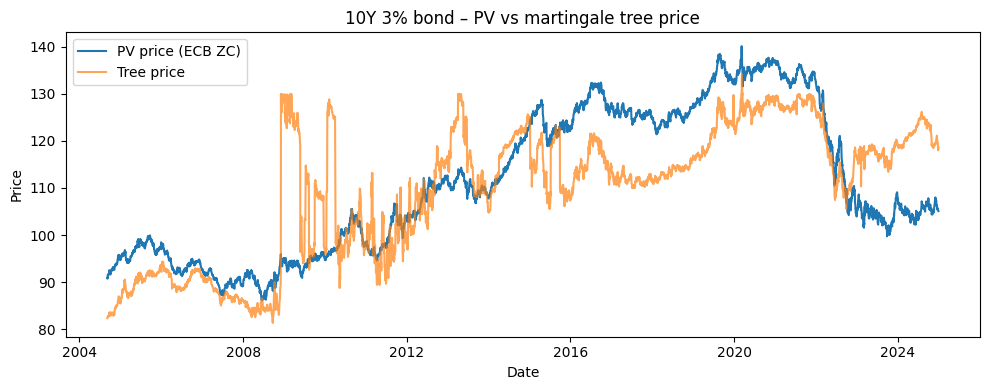

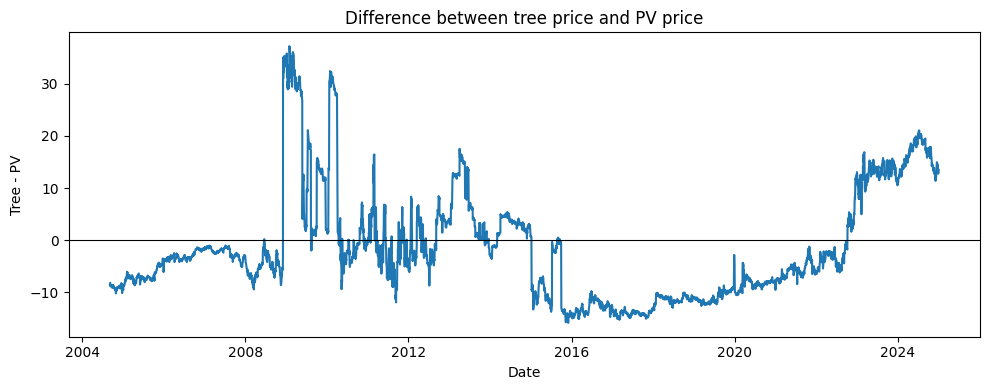

In [43]:
# Plot both price series
plt.figure(figsize=(10,4))
plt.plot(prices_all.index, prices_all["price_pv"], label="PV price (ECB ZC)")
plt.plot(prices_all.index, prices_all["price_tree"], label="Tree price", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("10Y 3% bond – PV vs martingale tree price")
plt.legend()
plt.tight_layout()
plt.show()

# Plot difference
plt.figure(figsize=(10,4))
plt.plot(prices_all.index, prices_all["diff_tree_minus_pv"])
plt.axhline(0, color="k", linewidth=0.8)
plt.xlabel("Date")
plt.ylabel("Tree - PV")
plt.title("Difference between tree price and PV price")
plt.tight_layout()
plt.show()

### Yield-curve factors (Level, Slope, Curvature) and VAR(1)


             Level        Slope    Curvature
count  5195.000000  5195.000000  5195.000000
mean      1.409686     1.045109    -0.131032
std       1.553175     0.957389     0.398067
min      -0.899697    -1.039346    -1.363132
25%      -0.156472     0.343621    -0.355340
50%       1.147597     1.006055    -0.207575
75%       2.687307     1.789448     0.063700
max       4.680163     3.288485     1.028704


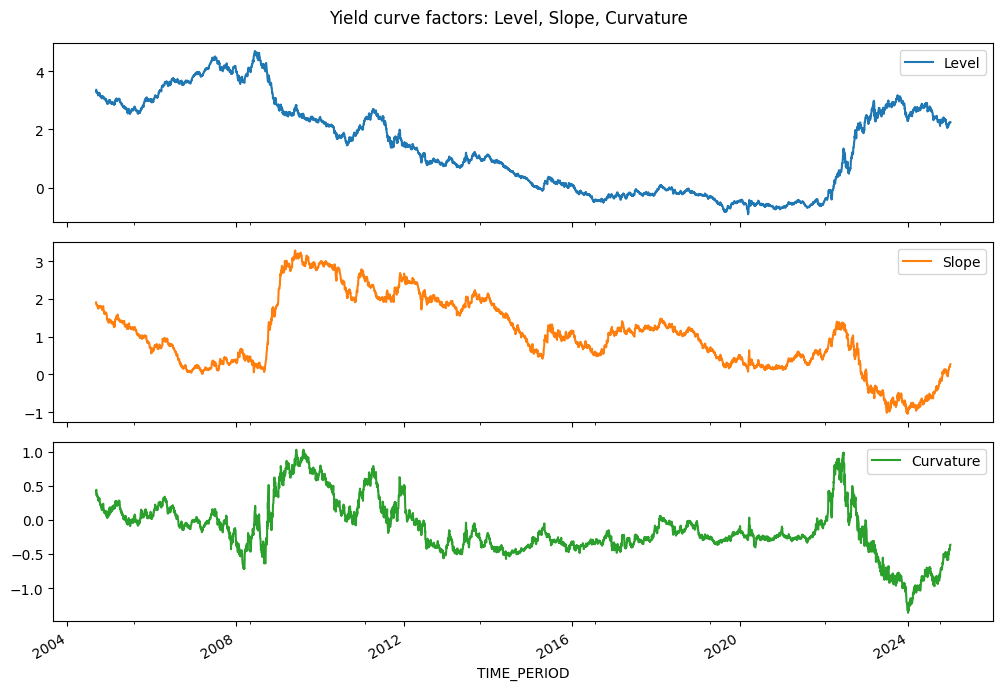

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 21, Nov, 2025
Time:                     20:42:05
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -21.0293
Nobs:                     5194.00    HQIC:                  -21.0391
Log likelihood:           32554.4    FPE:                7.25315e-10
AIC:                     -21.0444    Det(Omega_mle):     7.23642e-10
--------------------------------------------------------------------
Results for equation Level
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.000206         0.000466           -0.442           0.659
L1.Level             0.999362         0.000314         3177.889           0.000
L1.Slope            -0.002631         0.000691           -3.804 

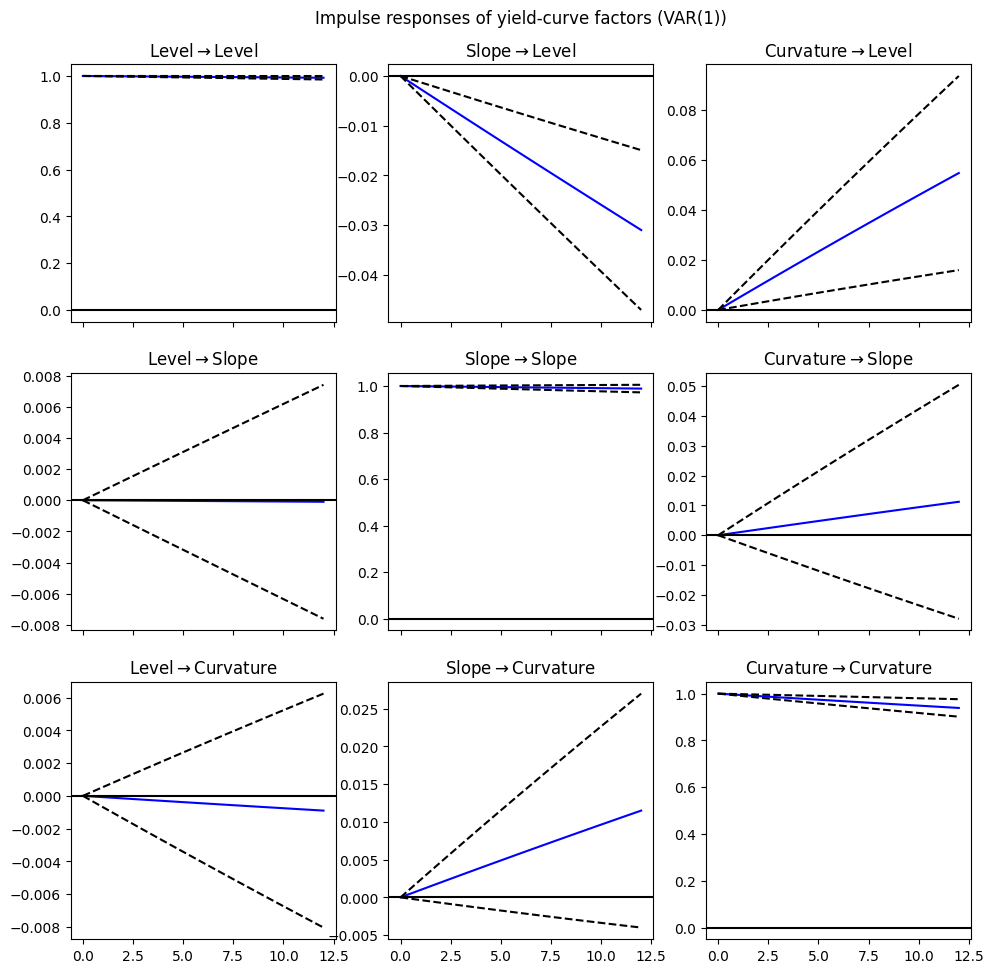

In [39]:
# Build Level, Slope, Curvature factors (in %)
factors = pd.DataFrame(index=yc_yields.index)
factors["Level"] = (yc_yields["y_1.0y"] + yc_yields["y_5.0y"] + yc_yields["y_10.0y"]) / 3.0
factors["Slope"] = yc_yields["y_10.0y"] - yc_yields["y_1.0y"]
factors["Curvature"] = 2 * yc_yields["y_5.0y"] - yc_yields["y_1.0y"] - yc_yields["y_10.0y"]

factors = factors.dropna()
print(factors.describe())

# Plot factors over time
factors.plot(subplots=True, figsize=(10, 7), sharex=True)
plt.suptitle("Yield curve factors: Level, Slope, Curvature")
plt.tight_layout()
plt.show()

# VAR(1) on (Level, Slope, Curvature)
from statsmodels.tsa.api import VAR

# Optionally demean
factors_var = factors - factors.mean()

model = VAR(factors_var)
var_res = model.fit(maxlags=1)
print(var_res.summary())

# Optional: impulse responses (12 periods ahead)
irf = var_res.irf(12)
irf.plot(orth=False)
plt.suptitle("Impulse responses of yield-curve factors (VAR(1))")
plt.show()